## Plot sputtering yield with respect to ion dose (cm^-2)

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [111]:
path2target = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/tersoff/deep_substrate/etch_files/0deg_1000eV'
# path2target = '/Users/y1u0d2/desktop/Lab/result/lammps/Si/sputtering/ml/atom16000/model_18/0deg_1000eV'

insert_atom_every_timestep = 20000
# width = 4.0725 # nm
width = 5.43 # nm
area = width**2

# number of injection to take average over
num_injection = 15

In [112]:
# get number of sputtered atoms and its timestep from log file
with open(os.path.join(path2target, 'etch.dat'), mode='r') as f:
    lines = [s.strip() for s in f.readlines()]

In [113]:
idx_list = []
for i, l in enumerate(lines):
    if 'ITEM: TIMESTEP' in l:
        idx_list.append(i)

idx_list_shift = idx_list[1:]
idx_list_shift.append(len(lines))

block = []
for idx1, idx2 in zip(idx_list, idx_list_shift):
    block.append(lines[idx1:idx2])

result = []
timestep_idx = 1
num_sputter_atom_idx = 3
for b in block:
    timestep = int(b[timestep_idx])
    num_sputter_atom = int(b[num_sputter_atom_idx])
    result.append(np.array([timestep, num_sputter_atom]))

sp_df = pd.DataFrame(result, columns=['timestep', 'num_sputter_atom'])

In [114]:
def get_num_inserted_atom(timestep, insert_atom_every_timestep):
    return (timestep // insert_atom_every_timestep) + 1

def get_ion_dose(area, timestep, insert_atom_every_timestep):
    return get_num_inserted_atom(timestep, insert_atom_every_timestep) / area

In [115]:
sp_df['num_inserted_atoms'] = sp_df['timestep'].apply(lambda x: get_num_inserted_atom(x, insert_atom_every_timestep))
sp_df['ion_dose'] = sp_df['timestep'].apply(lambda x: get_ion_dose(area, x, insert_atom_every_timestep))

In [116]:
max_num_inserted_atoms = sp_df['num_inserted_atoms'].max()

In [117]:
# remove duplicate records
sp_df_injection = sp_df.drop_duplicates(subset=['timestep'])
sp_df_injection = sp_df_injection.query('timestep % @insert_atom_every_timestep == 0')

In [118]:
# get average number of sputtered atoms
def get_averaged_num_sputtered_atoms(num_inserted_atoms, num_injection):
    lower = num_inserted_atoms - num_injection if num_inserted_atoms - num_injection > 0 else 0
    upper = num_inserted_atoms + num_injection if num_inserted_atoms + num_injection < max_num_inserted_atoms else max_num_inserted_atoms
    return sp_df.query('num_inserted_atoms >= @lower and num_inserted_atoms <= @upper')['num_sputter_atom'].sum() / (upper - lower + 1)

sp_df_injection['num_sputter_atom_avg'] = sp_df_injection['num_inserted_atoms'].apply(lambda x: get_averaged_num_sputtered_atoms(x, num_injection))

(-0.1, 2.0)

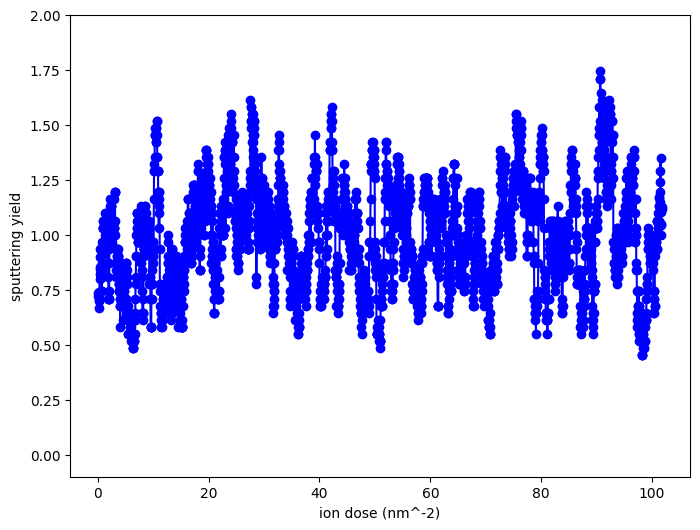

In [119]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(sp_df_injection['ion_dose'], sp_df_injection['num_sputter_atom_avg'], marker='o', color='blue', label='sputtering yield')
ax.set_xlabel('ion dose (nm^-2)')
ax.set_ylabel('sputtering yield')
ax.set_ylim(-.1, 2)

In [120]:
print('Mean of sputetring yield: ', sp_df_injection['num_sputter_atom_avg'].mean())
print('Std of sputetring yield: ', sp_df_injection['num_sputter_atom_avg'].std())

Mean of sputetring yield:  0.988198747017445
Std of sputetring yield:  0.23339211105577584


In [121]:
# get sputtering yield after converge
sp_df_injection_high_dose = sp_df_injection.query('20 < ion_dose')
print('Mean of sputetring yield for ion dose: ', sp_df_injection_high_dose['num_sputter_atom_avg'].mean())
print('Std of sputetring yield for ion dose: ', sp_df_injection_high_dose['num_sputter_atom_avg'].std())

Mean of sputetring yield for ion dose:  1.0071529460401292
Std of sputetring yield for ion dose:  0.23308970850185096
